In [341]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [316]:
df = pd.read_csv('https://raw.githubusercontent.com/data-bootcamp-v4/data/main/sales.csv')

In [317]:
display(df.head())
df.dtypes

,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,State_holiday,School_holiday,Sales
0,0,625,3,2013-11-06,641,1,1,0,0,7293
1,1,293,2,2013-07-16,877,1,1,0,1,7060
2,2,39,4,2014-01-23,561,1,1,0,0,4565
3,3,676,4,2013-09-26,1584,1,1,0,0,6380
4,4,709,3,2014-01-22,1477,1,1,0,0,11647


True_index              int64
Store_ID                int64
Day_of_week             int64
Date                   object
Nb_customers_on_day     int64
Open                    int64
Promotion               int64
State_holiday          object
School_holiday          int64
Sales                   int64
dtype: object

#### Store_ID is a nominal (categorical) variable.

We should address it as such, however, there is a large number of different values, so it is a bad idea to One-Hot encode them. We created bins to group stores by the number of sales.

In [318]:
df['Store_ID'].nunique()

1115

<Axes: xlabel='Sales', ylabel='Count'>

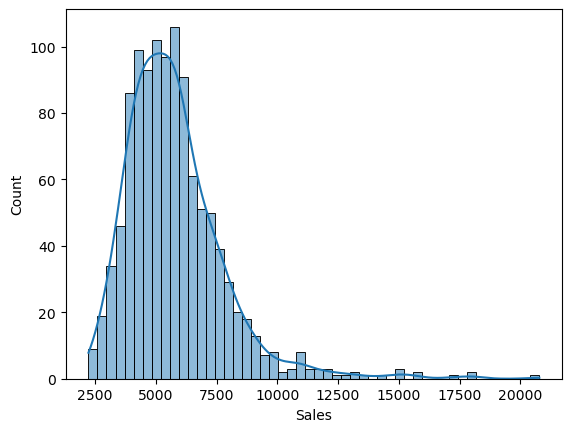

In [319]:
df_stores = df.groupby('Store_ID')['Sales'].mean().reset_index()
sns.histplot(df_stores['Sales'], bins=50, kde=True)

The distribution is far from Normal, it is tailed on the right-side with a few stores having larger number of sales. To account for that, we will group them in separate bins.

In [320]:
df['Store_sales'] = pd.cut(df['Sales'], bins = [0, 3750, 6250, 8750, 12500, 40000], labels = ['low', 'medium', 'moderate', 'high', 'vhigh'])

Now we get dummies for Store_sales column and split into 5 new columns storing boolean values.

In [321]:
store_dummies = pd.get_dummies(df['Store_sales'], dtype = 'bool', prefix='Store')
df = pd.concat([df, store_dummies], axis=1)
df.drop(columns=['Store_ID', 'Store_sales', 'True_index'], inplace=True)

We have the same approach for the day of the week, split into 7 columns storing boolean values.

In [322]:
df['Day_of_week'].replace({1:'Monday',
                           2:'Tuesday',
                           3:'Wednesday',
                           4:'Thursday',
                           5:'Friday',
                           6:'Saturday',
                           7:'Sunday'},
                           inplace=True)
days_week_dummies = pd.get_dummies(df['Day_of_week'], dtype = 'bool')
df = pd.concat([df, days_week_dummies], axis=1)
df.drop(columns='Day_of_week', inplace=True)

C:\Users\orian\AppData\Local\Temp\ipykernel_56896\2046343609.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Day_of_week'].replace({1:'Monday',


We have the same approach for State holiday, split into 4 columns storing boolean values.

In [323]:
df['State_holiday'].replace({'0':'No_holiday',
                           'a':'Holiday_a',
                           'b':'Holiday_b',
                           'c':'Holiday_c'},
                           inplace=True)
state_holiday_dummies = pd.get_dummies(df['State_holiday'], dtype = 'bool')
df = pd.concat([df, state_holiday_dummies], axis=1)
df.drop(columns='State_holiday', inplace=True)

C:\Users\orian\AppData\Local\Temp\ipykernel_56896\829463760.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['State_holiday'].replace({'0':'No_holiday',


### Casting as correct data type

Columns storing boolean valeus should be casted as such:

In [324]:
df['Open'] = df['Open'].astype('bool')
df['Promotion'] = df['Promotion'].astype('bool')
df['School_holiday'] = df['School_holiday'].astype('bool')

Date should be casted as date type:

In [325]:
df['Date'] = pd.to_datetime(df['Date'])

Now we can extract Year, month and day from Date column

In [326]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month_name()
df['day'] = df['Date'].dt.day
df.drop(columns='Date', inplace=True)

Create dummies for year and month

In [327]:
year_dummies = pd.get_dummies(df['year'], dtype = 'bool', prefix = 'year')
df = pd.concat([df, year_dummies], axis=1)
df.drop(columns='year', inplace=True)

In [328]:
month_dummies = pd.get_dummies(df['month'], dtype = 'bool')
df = pd.concat([df, month_dummies], axis=1)
df.drop(columns='month', inplace=True)
df

,Nb_customers_on_day,Open,Promotion,School_holiday,Sales,Store_low,Store_medium,Store_moderate,Store_high,Store_vhigh,...,December,February,January,July,June,March,May,November,October,September
0,641,True,True,False,7293,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
1,877,True,True,True,7060,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
2,561,True,True,False,4565,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,1584,True,True,False,6380,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1477,True,True,False,11647,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640835,611,True,False,False,4702,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
640836,1267,True,True,False,12545,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
640837,595,True,False,False,5823,False,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
640838,599,True,True,True,7986,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


Days create 31 columns, so we take the same approach as with Store_ID. Created 3 bins to categorise days as lo, medium and high. £ columns arise from those bins

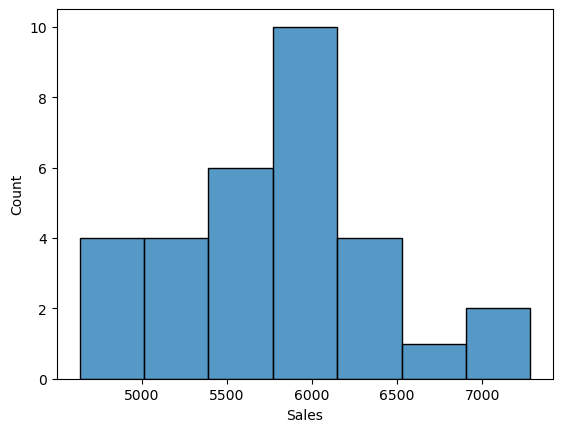

,Nb_customers_on_day,Open,Promotion,School_holiday,Sales,Store_low,Store_medium,Store_moderate,Store_high,Store_vhigh,...,July,June,March,May,November,October,September,Day_low,Day_medium,Day_high
0,641,True,True,False,7293,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,True
1,877,True,True,True,7060,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
2,561,True,True,False,4565,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1584,True,True,False,6380,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
4,1477,True,True,False,11647,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640835,611,True,False,False,4702,False,True,False,False,False,...,False,False,False,False,False,False,True,True,False,False
640836,1267,True,True,False,12545,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
640837,595,True,False,False,5823,False,True,False,False,False,...,False,True,False,False,False,False,False,False,True,False
640838,599,True,True,True,7986,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [329]:
df_days = df.groupby('day')['Sales'].mean().reset_index()
sns.histplot(df_days['Sales'])
plt.show()
df['Day_sales'] = pd.cut(df['Sales'], bins = [0, 5400, 6100, 40000], labels = ['low', 'medium', 'high'])
day_dummies = pd.get_dummies(df['Day_sales'], dtype = 'bool', prefix='Day')
df = pd.concat([df, day_dummies], axis=1)
df.drop(columns=['day', 'Day_sales'], inplace=True)
df

# Creation of the first model to Classify store being OPEN or NOT

First we select the categorical columns which store the features we deem important to classify the 'opennes' of the store

In [335]:
numerical = df.select_dtypes('number')
categorical = df.select_dtypes('bool')
categorical

,Open,Promotion,School_holiday,Store_low,Store_medium,Store_moderate,Store_high,Store_vhigh,Friday,Monday,...,July,June,March,May,November,October,September,Day_low,Day_medium,Day_high
0,True,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
1,True,True,True,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,True,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,True,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
4,True,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640835,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
640836,True,True,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
640837,True,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
640838,True,True,True,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [338]:
# Decide to keep or drop categorical variables. We do that by assessing (in)dependence with the target applying Chi2 tests.
categorical_drop = []
for column in categorical.columns:
    crosstab = pd.crosstab(index=categorical['Open'], columns=categorical[column])
    chi2_p_value = chi2_contingency(crosstab)[1]
    if chi2_p_value >= 0.05:   # Variable not related, drop it
        categorical_drop.append(column)

categorical_drop    # We'll drop the columns in this list as they are concluded to not be related to the target

['year_2013', 'year_2014', 'year_2015', 'January', 'March']

Split into train and test sets

In [ ]:
target = categorical['Open']
features = categorical.drop(columns=(categorical_drop + ['Open']))

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

Check for imbalanced data

Open
True     0.830185
False    0.169815
Name: proportion, dtype: float64


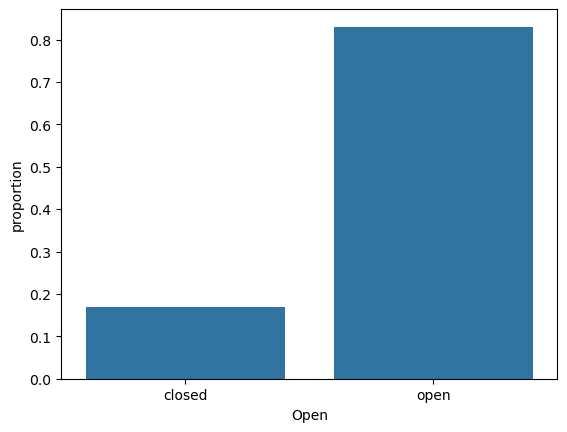

In [331]:
print(df['Open'].value_counts('normalised'))
sns.barplot(df['Open'].value_counts('normalised'))
plt.xticks([0,1], ['closed', 'open'])
plt.show()

We can see how the data is imbalanced towards open days. We have to resample, we decide to do it by SMOTE

In [ ]:
smote_sampler = SMOTE()

X_train_smote, y_train_smote = smote_sampler.fit_resample(X_train, y_train)  ## resampling

In [ ]:
# Choice of hyperparameters to randomise

grid = {'n_estimators' : np.arange(5,100),
        'max_depth' : np.arange(3,50),
        'max_leaf_nodes' : np.arange(5,50)}

In [ ]:
estimator = GradientBoostingClassifier()  ## Choice of ensemble method
model = RandomizedSearchCV(estimator, param_distributions = grid, n_iter = 36, cv = 5, n_jobs = -1)
model.fit (X_train_smote, y_train_smote)  # trains the model

In [ ]:
pred = model.best_estimator_.predict(X_test)   ## validation with test
print(classification_report(y_pred = pred, y_true = y_test))

In [332]:
#pickle.dump(<model_name>, open('model.pkl', 'wb'))
#loaded_model = pickle.load(open('model.pkl', 'rb'))